In [1]:
from ephys_queries import (
    select_spike_times, 
    select_ifr, 
    select_waveforms, 
    select_neurons
)
from ephys_queries import db_setup_core
from dotenv import load_dotenv

ModuleNotFoundError: No module named 'ephys_queries'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_palette("Set2")

In [3]:
from waveform_utils.waveforms import (
    waveform_peaks_by_neuron, 
    waveform_width_by_neuron,## Clustering of Acute Data
    peak_asymmetry_by_neuron
)
from spiketimes.df.statistics import (
    mean_firing_rate_by, 
    mean_firing_rate_ifr_by, 
    cv2_isi_by,
)

ModuleNotFoundError: No module named 'waveform_utils'

In [4]:
FS_MINUTE = 0.01666666666

## Clustering of Acute Data

Takes data from the **baseline period** of **treatment-naive** animals to assign each neurona type or label.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [6]:
import os

load_dotenv()
os.environ.get("DB_NAME")

'ephys'

### Select Raw Data

In [7]:
group_names = ["acute_citalopram", "acute_saline", "shock", 
               "sham", "acute_cit", "acute_sal"]
block_name = "pre"
fs = 30000

load_dotenv()
engine, metadata = db_setup_core()

spiketimes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)
waveforms = select_waveforms(engine, metadata,
                            group_names=group_names)
neurons = select_neurons(engine, metadata, group_names=group_names)

In [8]:
spiketimes.head()

,neuron_id,spike_time_samples,group_name,spiketimes
0,1,3318,shock,0.110600
1,1,21880,shock,0.729333
2,1,60284,shock,2.009467
3,1,96769,shock,3.225633
4,1,168821,shock,5.627367


### Engineer Features

In [9]:
mfr_ifr = mean_firing_rate_ifr_by(
    spiketimes,
    fs=FS_MINUTE,
    exclude_below=0.5,
    sigma=1,
    spiketimes_col="spiketimes",
    spiketrain_col="neuron_id"
    )
mfr = mean_firing_rate_by(
    spiketimes,
    spiketimes_col="spiketimes",
    spiketrain_col="neuron_id"
    )
cv_isi = cv2_isi_by(
    spiketimes,
    spiketimes_col="spiketimes",
    spiketrain_col="neuron_id"
    )
peaks = waveform_peaks_by_neuron(waveforms, neuron_col="neuron_id", 
                         index_col="waveform_index", 
                         value_col="waveform_value").dropna()
width = waveform_width_by_neuron(peaks, peak_names=["initiation", "ahp"])
peak_asym = peak_asymmetry_by_neuron(peaks, peak_names=["initiation", "ahp"])

/home/rory/miniconda3/envs/ssri/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Merge and Select Features For Clustering

In [10]:
df = (
    pd.merge(mfr_ifr, mfr)
    .merge(cv_isi)
    .merge(width)
    .merge(peak_asym)
)
df.head(2)

,neuron_id,mean_firing_rate_ifr,mean_firing_rate,cv2_isi,waveform_width,peak_asymmetry
0,1,0.918980,0.601693,0.467315,16.0,0.065574
1,4,3.521961,2.105512,0.824797,9.0,0.037344


### Apply Exclusion Criteria

In [11]:
df2 = (
    df[(df["mean_firing_rate_ifr"] > 0.2) & (df["cv2_isi"] < 1.2)]
    .copy()
    .dropna()
)

### Apply Clustering

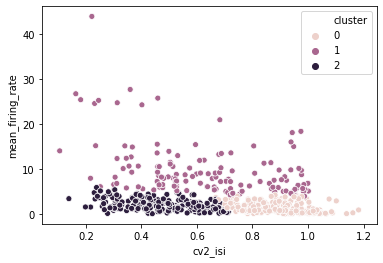

In [12]:
X = df2[["mean_firing_rate", "cv2_isi"]]
scaler = StandardScaler()
X = scaler.fit_transform(X)

model = GaussianMixture(3)
model.fit(X)
Y = model.predict(X)
df2["cluster"] = Y


sns.scatterplot(data=df2, x="cv2_isi", y="mean_firing_rate", hue="cluster")
plt.show()

### Add Cluster Labels

In [13]:
df2["cluster"] = df2.cluster.map({1: "fast_firing", 0: "slow_irregular", 2: "slow_regular"})

### Merge Data

In [14]:
df_acute = (df2
    .pipe(lambda x: pd.merge(x, df, how="outer"))
    .pipe(lambda x: pd.merge(x, neurons, how="outer", left_on="neuron_id", right_on="id"))
)
df_acute["neuron_id"] = df_acute["neuron_id"].fillna(df_acute["id"])
df_acute = df_acute.drop(["recording_session_id", "cluster_id", "id"], axis=1)
df_acute["cluster"] = df_acute["cluster"].fillna("no_baseline")
df_acute.neuron_id = df_acute.neuron_id.astype(int)
df_acute.head(2)

,neuron_id,mean_firing_rate_ifr,mean_firing_rate,cv2_isi,waveform_width,peak_asymmetry,cluster,channel,is_single_unit,session_name,group_name,experiment_name
0,1,0.918980,0.601693,0.467315,16.0,0.065574,slow_regular,6,1,ESHOCK_03_LOC1,shock,ESHOCK
1,4,3.521961,2.105512,0.824797,9.0,0.037344,slow_irregular,17,1,ESHOCK_03_LOC1,shock,ESHOCK


## Classifying Chronic Data

Takes data from the **baseline period** of **treatment-receiving** animals to assign each neurona type or label.

In [15]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC

### Select Raw Data

In [16]:
group_names = ["citalopram_continuation", "chronic_saline", "citalopram_discontinuation", 
               "chronic_citalopram", "chronic_saline_"]
block_name = "pre"

engine, metadata = db_setup_core()


spiketimes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)
waveforms = select_waveforms(engine, metadata,
                            group_names=group_names)
neurons = select_neurons(engine, metadata, group_names=group_names)

### Engineer Features

In [17]:
mfr_ifr = mean_firing_rate_ifr_by(
    spiketimes,
    fs=FS_MINUTE,
    exclude_below=0.5,
    sigma=1,
    spiketimes_col="spiketimes",
    spiketrain_col="neuron_id"
    )
mfr = mean_firing_rate_by(
    spiketimes,
    spiketimes_col="spiketimes",
    spiketrain_col="neuron_id"
    )
cv_isi = cv2_isi_by(
    spiketimes,
    spiketimes_col="spiketimes",
    spiketrain_col="neuron_id"
    )
peaks = waveform_peaks_by_neuron(waveforms, neuron_col="neuron_id", 
                         index_col="waveform_index", 
                         value_col="waveform_value").dropna()
width = waveform_width_by_neuron(peaks, peak_names=["initiation", "ahp"])
peak_asym = peak_asymmetry_by_neuron(peaks, peak_names=["initiation", "ahp"])

/home/rory/miniconda3/envs/ssri/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/rory/miniconda3/envs/ssri/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rory/miniconda3/envs/ssri/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Merge and Select Features For Classification

In [18]:
df = (
    pd.merge(mfr_ifr, mfr)
    .merge(cv_isi)
    .merge(width)
    .merge(peak_asym)
)
df.head(2)

,neuron_id,mean_firing_rate_ifr,mean_firing_rate,cv2_isi,waveform_width,peak_asymmetry
0,1069,1.596687,0.902333,1.005615,25.0,0.101215
1,1070,6.099822,3.129088,0.999278,41.0,0.157088


### Apply Exclusion Criteria

In [19]:
df2 = (
    df[(df["mean_firing_rate_ifr"] > 0.2) & (df["cv2_isi"] < 1.2)]
    .copy()
    .dropna()
)

### Apply Classification

In [24]:
df_acute2 = df_acute[df_acute["cluster"] != "no_baseline"]

y_train = df_acute2["cluster"].values
X_train = df_acute2[["mean_firing_rate", "cv2_isi"]].values

X_test = df2[["mean_firing_rate", "cv2_isi"]].values

le = LabelEncoder()
y_train = le.fit_transform(y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SVC(kernel='rbf', C=1E6)
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
df2["cluster"] = le.inverse_transform(y_hat) 

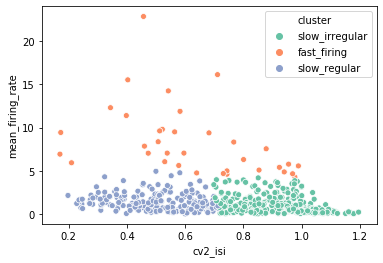

In [25]:
sns.scatterplot(data=df2, x="cv2_isi", y="mean_firing_rate", hue="cluster")
plt.show()

### Merge Data

In [26]:
df_chronic_baseline = (df2
    .pipe(lambda x: pd.merge(x, df, how="outer"))
    .pipe(lambda x: pd.merge(x, neurons, how="outer", left_on="neuron_id", right_on="id"))
)
df_chronic_baseline["neuron_id"] = df_chronic_baseline["neuron_id"].fillna(df_chronic_baseline["id"])
df_chronic_baseline["cluster"] = df_chronic_baseline["cluster"].fillna("no_baseline")
df_chronic_baseline = df_chronic_baseline.drop(["recording_session_id", "cluster_id", "id"], axis=1)

df_chronic_baseline.neuron_id = df_chronic_baseline.neuron_id.astype(int)

## Merge Acute and Chronic then Save


In [27]:
data_dir = Path(".").absolute().parent / "data"
data_dir.mkdir(exist_ok=True)


df_baseline = pd.concat([df_acute, df_chronic_baseline])
df_baseline.to_csv(data_dir / "baseline.csv", index=False)